In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import json
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import seaborn as sns
import torch

In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajaym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# def clean_text(text):
#     text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
#     text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
#     text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
#     return text.strip()

def clean_text(text):
    # Replace \n with a space
    text = re.sub(r'\n', ' ', text)

    # Replace encoded apostrophes and quotes with plain text equivalents
    text = text.replace('\x92', "'")  # Right single quote
    text = text.replace('\x93', '"')  # Left double quote
    text = text.replace('\x94', '"')  # Right double quote
    text = text.replace('\xa0', ' ')  # Non-breaking space

    # Remove other \x.. sequences
    text = re.sub(r'\\x[0-9A-Fa-f]{2}', '', text)
    
    # Fix spacing issues around periods and capitalization
    text = re.sub(r'\s*\.\s*', '. ', text)
    text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
    
    return text.strip()

In [4]:
def split_sentences_with_nltk(text):
    # Initial cleaning
    text = clean_text(text)

    # Use nltk's sentence tokenizer
    sentences = re.split(r'(?<=[.,;])\s*', text)

    # Post-process to remove redundant or empty sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

In [5]:
def converttotext(url):
    headers = {'User-Agent':'Sample Company Name AdminContact@<sample company domain>.com','Accept-Encoding':'gzip, deflate','Host':'www.sec.gov'}

    r = requests.get(url, headers=headers)

    raw_10k = r.text

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|3|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|3|7A|7|8))')

    matches = regex.finditer(document['10-K'])

    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()
    test_df.head()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace(' ','',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace('>','',regex=True,inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]
    item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')

    # item_3_raw = document['10-K'][pos_dat['start'].loc['item3']:pos_dat['start'].loc['item7']]
    # item_3_content = BeautifulSoup(item_3_raw, 'lxml')

    # item_7_raw = document['10-K'][pos_dat['start'].loc['item7']:pos_dat['start'].loc['item7a']]
    # item_7_content = BeautifulSoup(item_7_raw, 'lxml')

    # item_7a_raw = document['10-K'][pos_dat['start'].loc['item7a']:pos_dat['start'].loc['item8']]
    # item_7a_content = BeautifulSoup(item_7a_raw, 'lxml')

    item_1a_text = item_1a_content.get_text()
    # item_3_text = item_3_content.get_text()
    # item_7_text = item_7_content.get_text()
    # item_7a_text = item_7a_content.get_text()

    sentences = split_sentences_with_nltk(item_1a_text)
    # sentences += split_sentences_with_nltk(item_3_text)
    # sentences += split_sentences_with_nltk(item_7_text)
    # sentences += split_sentences_with_nltk(item_7a_text)
    
    return sentences

In [6]:
# sentences = converttotext('https://www.sec.gov/Archives/edgar/data/0001018724/000101872424000008/0001018724-24-000008.txt')
# print(len(sentences))
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
# finbert.to("cuda")
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
# nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512, device=0)
# results = nlp(sentences)

# environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
# social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
# governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

# environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
# social_score_avg = sum(social_score) / len(social_score) if social_score else 0
# governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

# print(f'Average Environmental Score: {environment_score_avg}')
# print(f'Average Social Score: {social_score_avg}')
# print(f'Average Governance Score: {governance_score_avg}')

In [7]:
# def calculate_average_esg(sentences, nlp):
#     results = nlp(sentences)

#     # Extract scores for each category
#     environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
#     social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
#     governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

#     # Calculate averages or set to 0 if no scores are found
#     environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
#     social_score_avg = sum(social_score) / len(social_score) if social_score else 0
#     governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

#     return {
#         'environment_score_avg': environment_score_avg,
#         'social_score_avg': social_score_avg,
#         'governance_score_avg': governance_score_avg
#     }

In [8]:
def calculate_average_and_std_esg(sentences, nlp):
    results = nlp(sentences)

    # Extract scores for each category
    environment_scores = [entry['score'] for entry in results if entry['label'] == 'Environmental']
    social_scores = [entry['score'] for entry in results if entry['label'] == 'Social']
    governance_scores = [entry['score'] for entry in results if entry['label'] == 'Governance']

    # Calculate averages or set to 0 if no scores are found
    environment_score_avg = sum(environment_scores) / len(environment_scores) if environment_scores else 0
    social_score_avg = sum(social_scores) / len(social_scores) if social_scores else 0
    governance_score_avg = sum(governance_scores) / len(governance_scores) if governance_scores else 0

    # Calculate standard deviations or set to 0 if no scores are found
    environment_score_std = math.sqrt(sum((x - environment_score_avg) ** 2 for x in environment_scores) / len(environment_scores)) if environment_scores else 0
    social_score_std = math.sqrt(sum((x - social_score_avg) ** 2 for x in social_scores) / len(social_scores)) if social_scores else 0
    governance_score_std = math.sqrt(sum((x - governance_score_avg) ** 2 for x in governance_scores) / len(governance_scores)) if governance_scores else 0

    return {
        'environment_score_avg': environment_score_avg,
        'environment_score_std': environment_score_std,
        'social_score_avg': social_score_avg,
        'social_score_std': social_score_std,
        'governance_score_avg': governance_score_avg,
        'governance_score_std': governance_score_std
    }

In [9]:
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
# nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512)

# target_year = 2024

# with open(f"../Edgar/10K-URL/All_10K_Filings_{target_year}.json", "r") as read_file:
#     companies = json.load(read_file)

# valid_companies = []

# for company in companies:
#     try:
#         print(f"Analysing: {company['company']}")
#         sentences = converttotext(company['url'])
#         print(f"Number of sentences: {len(sentences)}")

#         if len(sentences) > 10:
#             scores = calculate_average_esg(sentences, nlp)
        
#             company['environment_score_avg'] = scores['environment_score_avg']
#             company['social_score_avg'] = scores['social_score_avg']
#             company['governance_score_avg'] = scores['governance_score_avg']
        
#             valid_companies.append(company)

#     except Exception as e:
#         print(f"Error processing {company['company']}: {e}")

# final_companies = [company['company'] for company in valid_companies]
# print(f"Companies processed: {final_companies}")

# if valid_companies:
#     environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
#     social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
#     governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

#     print(f'Average Environmental Score: {environment_avg}')
#     print(f'Average Social Score: {social_avg}')
#     print(f'Average Governance Score: {governance_avg}')
# else:
#     print("No valid companies to calculate averages.")

In [10]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512, device=0)

Device set to use cuda:0


In [11]:
# Define the target year and industry
target_years = range(2019, 2024)  # Change this to the desired year
industry = "TECH"   # Change this to the desired industry (TECH, OIL, HEALTH)

# Initialize lists to store scores for each company


# Load the data for the target year
for target_year in target_years:
    try:
        with open(f"../Edgar/10K_URL_{industry}/All_10K_Filings_{target_year}.json", "r") as read_file:
            companies = json.load(read_file)

        # Process each company
        company_scores = []
        
        for company in tqdm(companies, desc=f"Processing {target_year}"):
            try:
                # Convert the 10-K filing to sentences
                sentences = converttotext(company['url'])
                print(f"Company: {company['company']}, Sentence count: {len(sentences)}")

                # Ensure there are enough sentences to process
                if len(sentences) > 200:
                    # Calculate ESG scores
                    scores = calculate_average_and_std_esg(sentences, nlp)

                    # Store the scores for the company
                    company_scores.append({
                        "company": company['company'],
                        "environment_score_avg": scores['environment_score_avg'],
                        "social_score_avg": scores['social_score_avg'],
                        "governance_score_avg": scores['governance_score_avg'],
                        "environment_score_std": scores['environment_score_std'],
                        "social_score_std": scores['social_score_std'],
                        "governance_score_std": scores['governance_score_std']
                    })

            except Exception as e:
                print(f"Error processing {company['company']}: {e}")
        
        output_file = f"ESG_Scores_{industry}_{target_year}.json"
        with open(output_file, "w") as write_file:
            json.dump(company_scores, write_file, indent=4)

        print(f"\nResults saved to {output_file}")

    except Exception as e:
        print(f"Error loading data for year {target_year}: {e}")


Processing 2019:   0%|          | 0/30 [00:00<?, ?it/s]

Company: AAPL, Sentence count: 851


Processing 2019:   3%|▎         | 1/30 [00:06<02:57,  6.13s/it]

Company: AMZN, Sentence count: 887


Processing 2019:   3%|▎         | 1/30 [00:07<03:43,  7.72s/it]


KeyboardInterrupt: 

In [12]:
target_years = range(2019, 2023)
industry = "TECH"
# TECH, OIL, HEALTH

environment_scores = []
environment_stds = []
social_scores = []
social_stds = []
governance_scores = []
governance_stds = []

for target_year in tqdm(target_years):
    print(f"Processing year: {target_year}")

    try:
        with open(f"../Edgar/10K_URL_{industry}/All_10K_Filings_{target_year}.json", "r") as read_file:
            companies = json.load(read_file)

        valid_companies = []

        for company in companies:
            try:
                sentences = converttotext(company['url'])
                print(f"Company: {company['company']}, Sentence count: {len(sentences)}")

                if len(sentences) > 200:
                    # scores = calculate_average_esg(sentences, nlp)
                    scores = calculate_average_and_std_esg(sentences, nlp)
                
                    company['environment_score_avg'] = scores['environment_score_avg']
                    company['social_score_avg'] = scores['social_score_avg']
                    company['governance_score_avg'] = scores['governance_score_avg']

                    # company['environment_score_std'] = scores['environment_score_std']
                    # company['social_score_std'] = scores['social_score_std']
                    # company['governance_score_std'] = scores['governance_score_std']
                
                    valid_companies.append(company)

            except Exception as e:
                print(f"Error processing {company['company']}: {e}")

        final_companies = [company['company'] for company in valid_companies]
        print(f"Companies processed: {final_companies}")

        if valid_companies:
            # environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
            # social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
            # governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

            # environment_scores.append(environment_avg)
            # social_scores.append(social_avg)
            # governance_scores.append(governance_avg)

            environment_avg_list = [company['environment_score_avg'] for company in valid_companies]
            social_avg_list = [company['social_score_avg'] for company in valid_companies]
            governance_avg_list = [company['governance_score_avg'] for company in valid_companies]

            environment_scores.append(np.mean(environment_avg_list))
            environment_stds.append(np.std(environment_avg_list, ddof=1) if len(environment_avg_list) > 1 else 0)

            social_scores.append(np.mean(social_avg_list))
            social_stds.append(np.std(social_avg_list, ddof=1) if len(social_avg_list) > 1 else 0)

            governance_scores.append(np.mean(governance_avg_list))
            governance_stds.append(np.std(governance_avg_list, ddof=1) if len(governance_avg_list) > 1 else 0)

    except Exception as e:
        print(f"Error processing year {target_year}: {e}")

  0%|          | 0/4 [00:00<?, ?it/s]

Processing year: 2019
Company: AAPL, Sentence count: 851
Company: AMZN, Sentence count: 887
Company: NVDA, Sentence count: 709
Company: MSFT, Sentence count: 74
Company: ORCL, Sentence count: 1095
Company: CSCO, Sentence count: 1148
Company: META, Sentence count: 1932
Company: INTC, Sentence count: 2
Company: GOOGL, Sentence count: 2
Company: NFLX, Sentence count: 910
Error processing T: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: MU, Sentence count: 1434


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Company: A, Sentence count: 862
Company: IBM, Sentence count: 2
Company: HPQ, Sentence count: 1367
Company: CMCSA, Sentence count: 619
Company: INTU, Sentence count: 1064
Company: ADTN, Sentence count: 1117
Company: CPT, Sentence count: 515
Company: CI, Sentence count: 46
Company: UI, Sentence count: 1733
Company: ONDS, Sentence count: 1213
Error processing BR: 'item1a'
Company: ARR, Sentence count: 1379
Company: TSLA, Sentence count: 0
Company: LIN, Sentence count: 469
Company: VRSK, Sentence count: 717
Company: UUUU, Sentence count: 1398
Company: ARES, Sentence count: 3920
Company: RARE, Sentence count: 2706


 25%|██▌       | 1/4 [03:12<09:38, 192.73s/it]

Companies processed: ['AAPL', 'AMZN', 'NVDA', 'ORCL', 'CSCO', 'META', 'NFLX', 'MU', 'A', 'HPQ', 'CMCSA', 'INTU', 'ADTN', 'CPT', 'UI', 'ONDS', 'ARR', 'LIN', 'VRSK', 'UUUU', 'ARES', 'RARE']
Processing year: 2020
Company: AAPL, Sentence count: 953
Company: AMZN, Sentence count: 986
Company: NVDA, Sentence count: 770
Company: MSFT, Sentence count: 45
Company: ORCL, Sentence count: 1173
Company: CSCO, Sentence count: 1257
Company: META, Sentence count: 2346
Error processing INTC: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Company: GOOGL, Sentence count: 2
Company: NFLX, Sentence count: 981
Error processing T: 'item1b'
Company: MU, Sentence count: 1491
Company: A, Sentence count: 944
Company: IBM, Sentence count: 2
Company: HPQ, Sentence count: 1431
Company: CMCSA, Sentence count: 607
Company: INTU, Sentence count: 1267
Company: ADTN, Sentence count: 1142
Company: CPT, Sentence count: 470
Company: CI, Sentence count: 1180
Company: UI, Sentence count: 1872
Error

 50%|█████     | 2/4 [06:58<07:04, 212.25s/it]

Companies processed: ['AAPL', 'AMZN', 'NVDA', 'ORCL', 'CSCO', 'META', 'NFLX', 'MU', 'A', 'HPQ', 'CMCSA', 'INTU', 'ADTN', 'CPT', 'CI', 'UI', 'BR', 'ARR', 'LIN', 'VRSK', 'UUUU', 'ARES', 'RARE']
Processing year: 2021
Company: AAPL, Sentence count: 1049
Company: AMZN, Sentence count: 999
Company: NVDA, Sentence count: 1159
Company: MSFT, Sentence count: 59
Company: ORCL, Sentence count: 1098
Company: CSCO, Sentence count: 1227
Company: META, Sentence count: 2744
Company: INTC, Sentence count: 2
Company: GOOGL, Sentence count: 1381
Company: NFLX, Sentence count: 1079
Error processing T: 'item1b'
Company: MU, Sentence count: 1743
Company: A, Sentence count: 971
Company: IBM, Sentence count: 2
Company: HPQ, Sentence count: 1446
Company: CMCSA, Sentence count: 657
Company: INTU, Sentence count: 1267
Company: ADTN, Sentence count: 1078
Company: CPT, Sentence count: 506
Company: CI, Sentence count: 1256
Company: UI, Sentence count: 2106
Company: ONDS, Sentence count: 1287
Company: BR, Sentence c

 75%|███████▌  | 3/4 [11:50<04:08, 248.54s/it]

Companies processed: ['AAPL', 'AMZN', 'NVDA', 'ORCL', 'CSCO', 'META', 'GOOGL', 'NFLX', 'MU', 'A', 'HPQ', 'CMCSA', 'INTU', 'ADTN', 'CPT', 'CI', 'UI', 'ONDS', 'BR', 'DASH', 'UPST', 'ARR', 'LIN', 'VRSK', 'UUUU', 'ARES', 'RARE']
Processing year: 2022
Company: AAPL, Sentence count: 1126
Company: AMZN, Sentence count: 1054
Company: NVDA, Sentence count: 1207
Company: MSFT, Sentence count: 86
Company: ORCL, Sentence count: 1162
Company: CSCO, Sentence count: 1354
Company: META, Sentence count: 2941
Company: INTC, Sentence count: 2
Company: GOOGL, Sentence count: 1488
Company: NFLX, Sentence count: 1087
Error processing T: 'item1b'
Company: MU, Sentence count: 1519
Company: A, Sentence count: 951
Company: IBM, Sentence count: 2
Company: HPQ, Sentence count: 1354
Company: CMCSA, Sentence count: 659
Company: INTU, Sentence count: 1253
Company: ADTN, Sentence count: 1440
Company: CPT, Sentence count: 491
Company: CI, Sentence count: 1343
Company: UI, Sentence count: 2234
Error processing ONDS: 'i

100%|██████████| 4/4 [16:53<00:00, 253.34s/it]

Companies processed: ['AAPL', 'AMZN', 'NVDA', 'ORCL', 'CSCO', 'META', 'GOOGL', 'NFLX', 'MU', 'A', 'HPQ', 'CMCSA', 'INTU', 'ADTN', 'CPT', 'CI', 'UI', 'BR', 'DASH', 'UPST', 'ARR', 'TSLA', 'LIN', 'VRSK', 'UUUU', 'ARES', 'RARE']


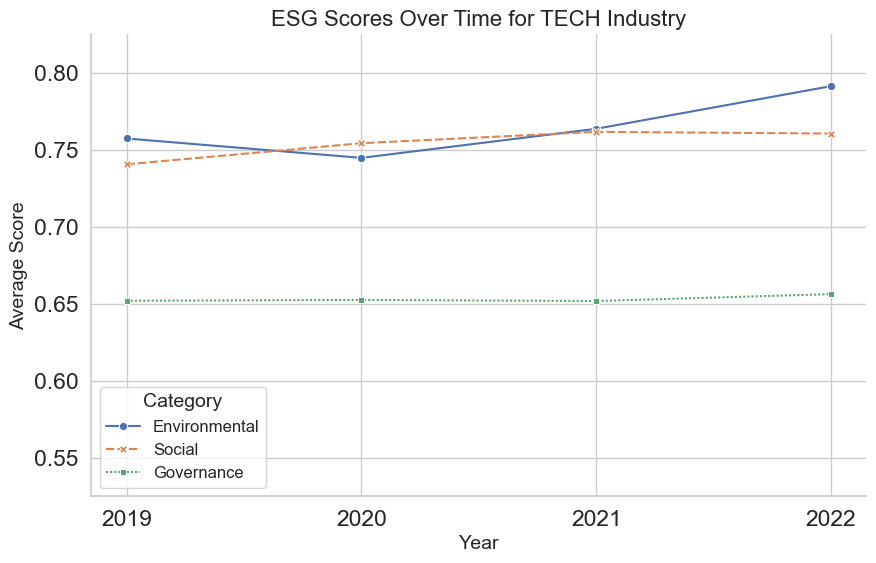

In [19]:
data = {
    "Year": list(target_years),
    "Environmental": environment_scores,
    "Environmental_SD": environment_stds,
    "Social": social_scores,
    "Social_SD": social_stds,
    "Governance": governance_scores,
    "Governance_SD": governance_stds
}

# Convert to a DataFrame for Seaborn compatibility
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting with Seaborn
df_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental", "Social", "Governance"], 
    var_name="Category", 
    value_name="Score"
)

# Add a column for the corresponding standard deviations
std_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental_SD", "Social_SD", "Governance_SD"], 
    var_name="Category", 
    value_name="Standard_Deviation"
)

std_melted["Category"] = std_melted["Category"].str.replace("_SD", "")

df_melted = df_melted.merge(std_melted, on=["Year", "Category"], how="left")

sns.set(style="whitegrid", font_scale=1.5)  # Increase font size

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the lineplot
sns.lineplot(
    data=df_melted, 
    x="Year", 
    y="Score", 
    hue="Category", 
    style="Category",
    markers=True,
    errorbar=None  # Disable automatic confidence intervals
)

# Add error bars
# for category in df_melted["Category"].unique():
#     if category == "Governance":  # Specify the category for which to show error bars
#         subset = df_melted[df_melted["Category"] == category]
#         plt.errorbar(
#             subset["Year"], 
#             subset["Score"], 
#             yerr=subset["Standard_Deviation"], 
#             fmt='o', 
#             capsize=5, 
#             color=sns.color_palette()[df_melted["Category"].unique().tolist().index(category)]
#         )

# for category in df_melted["Category"].unique():
#     subset = df_melted[df_melted["Category"] == category]
#     plt.errorbar(
#         subset["Year"], 
#         subset["Score"], 
#         yerr=subset["Standard_Deviation"], 
#         fmt='o', 
#         capsize=5, 
#         color=sns.color_palette()[df_melted["Category"].unique().tolist().index(category)]
#     )
    
# Remove top and right borders
sns.despine(top=True, right=True)

# Set x-ticks and y-limits
plt.xticks(ticks=df["Year"], labels=df["Year"])
plt.ylim(0.525, 0.825)

# Add titles and labels
plt.title(f"ESG Scores Over Time for {industry} Industry", fontsize=16)  # Increase title font size
plt.xlabel("Year", fontsize=14)  # Increase x-label font size
plt.ylabel("Average Score", fontsize=14)  # Increase y-label font size
plt.legend(title="Category", title_fontsize=14, fontsize=12)  # Adjust legend font size

# Show the plot
plt.show()

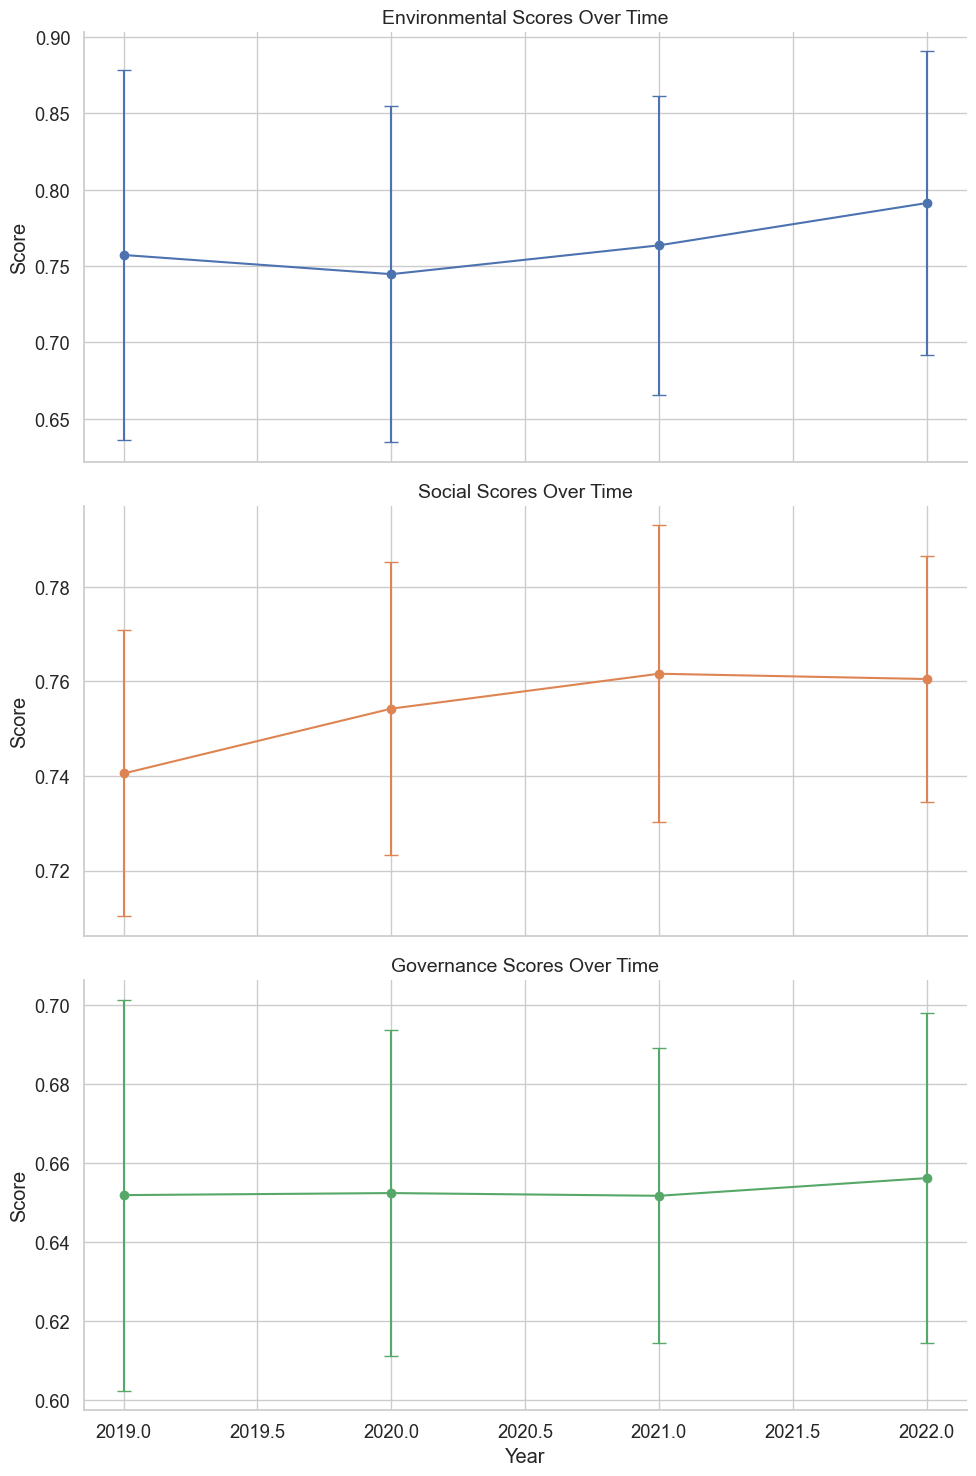

In [14]:
sns.set(style="whitegrid", font_scale=1.2)

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Define the categories and their corresponding axes
categories = ["Environmental", "Social", "Governance"]

for i, category in enumerate(categories):
    ax = axes[i]
    
    # Subset data for the current category
    subset = df[["Year", category, f"{category}_SD"]]
    
    # Plot the lineplot
    sns.lineplot(
        data=subset,
        x="Year",
        y=category,
        ax=ax,
        marker='o',
        color=sns.color_palette()[i]
    )
    
    # Add error bars
    ax.errorbar(
        subset["Year"],
        subset[category],
        yerr=subset[f"{category}_SD"],
        fmt='o',
        capsize=5,
        color=sns.color_palette()[i]
    )
    
    # Titles and labels
    ax.set_title(f"{category} Scores Over Time", fontsize=14)
    ax.set_ylabel("Score")
    ax.set_xlabel("Year")
    
    # Customize grid and borders
    sns.despine(ax=ax, top=True, right=True)

# Adjust layout for spacing
plt.tight_layout()

# Show the plot
plt.show()

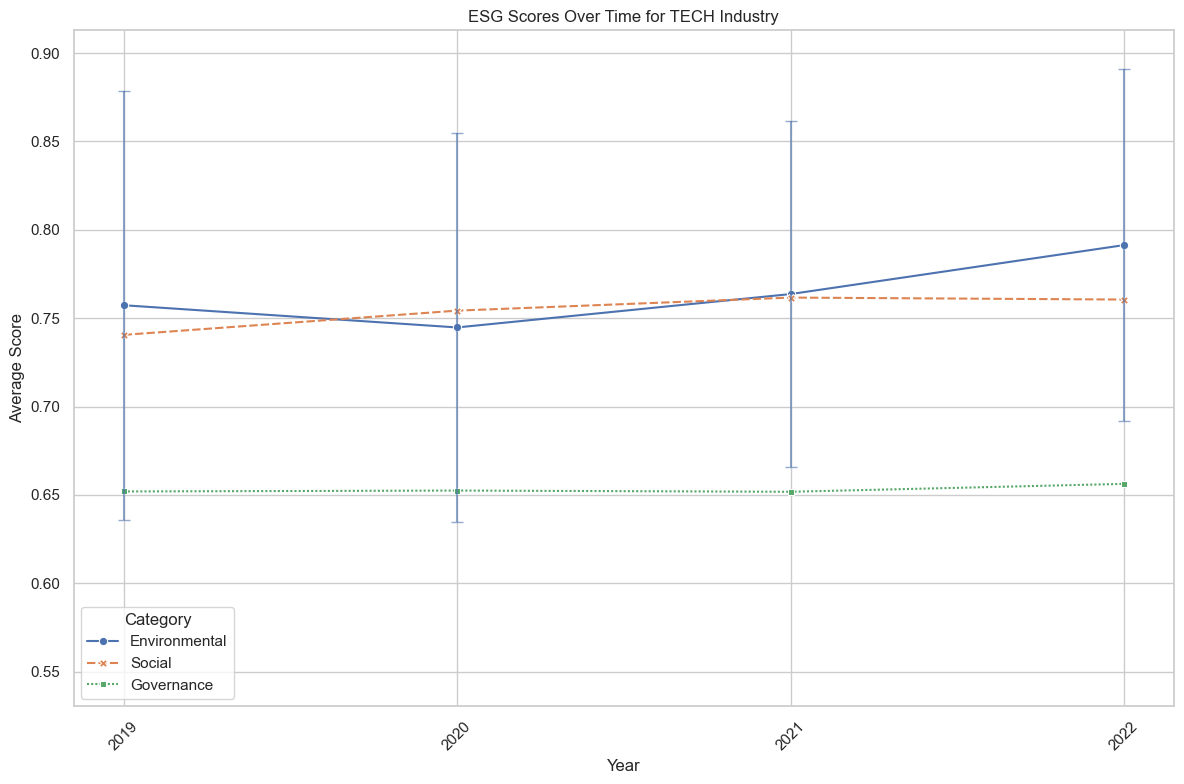

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming target_years, environment_scores, environment_stds, social_scores, social_stds,
# governance_scores, and governance_stds are already defined

# Prepare the data
data = {
    "Year": list(target_years),
    "Environmental": environment_scores,
    "Environmental_SD": environment_stds,
    "Social": social_scores,
    "Social_SD": social_stds,
    "Governance": governance_scores,
    "Governance_SD": governance_stds
}

# Convert to a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for easier plotting with Seaborn
df_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental", "Social", "Governance"], 
    var_name="Category", 
    value_name="Score"
)

# Melt the standard deviations
std_melted = df.melt(
    id_vars=["Year"], 
    value_vars=["Environmental_SD", "Social_SD", "Governance_SD"], 
    var_name="Category", 
    value_name="Standard_Deviation"
)

# Map standard deviation values to the melted data
df_melted["Standard_Deviation"] = std_melted["Standard_Deviation"]

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.lineplot(
    data=df_melted,
    x="Year",
    y="Score",
    hue="Category",
    style="Category",
    markers=True,
    errorbar=None  # Disable Seaborn's default error bars
)

# Add custom error bars using Matplotlib
# for category in df_melted["Category"].unique():
#     subset = df_melted[df_melted["Category"] == category]
#     plt.errorbar(
#         subset["Year"], 
#         subset["Score"], 
#         yerr=subset["Standard_Deviation"], 
#         fmt="none", 
#         capsize=4, 
#         label=None, 
#         alpha=0.6  # Add some transparency to the error bars
#     )

subset_env = df_melted[df_melted["Category"] == "Environmental"]
plt.errorbar(
    subset_env["Year"], 
    subset_env["Score"], 
    yerr=subset_env["Standard_Deviation"], 
    fmt="none", 
    capsize=4, 
    label=None, 
    alpha=0.6  # Add some transparency to the error bars
)

# Adjust y-axis if error bars are too large
all_scores = df_melted["Score"]
all_errors = df_melted["Standard_Deviation"].fillna(0)
ymin = max(0, all_scores.min() - all_errors.max())
ymax = all_scores.max() + all_errors.max()
plt.ylim(ymin, ymax)

plt.xticks(ticks=df["Year"].unique(), labels=df["Year"].unique(), rotation=45)
plt.title(f"ESG Scores Over Time for {industry} Industry")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend(title="Category")
plt.tight_layout()
plt.show()


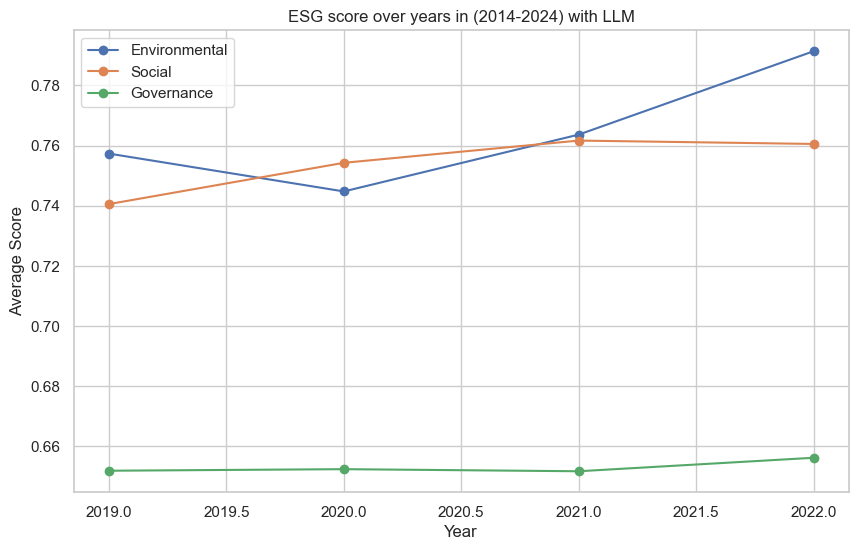

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(target_years, environment_scores, label='Environmental', marker='o')
plt.plot(target_years, social_scores, label='Social', marker='o')
plt.plot(target_years, governance_scores, label='Governance', marker='o')

plt.title("ESG score over years in (2014-2024) with LLM")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend()
plt.show()